In [30]:
import pandas as pd
import numpy as np

In [70]:
def portfolioDiagnostics(signal_df, label):
    #NET SECTOR EXPOSURES
    import matplotlib.pyplot as plt
    plt.figure();
    #sector_df = pd.read_csv("sector.csv", error_bad_lines = False)
    sector_df = pd.read_csv("sector.csv", on_bad_lines='skip')
    d = sector_df.set_index('ticker').to_dict()
    signal_df2 = signal_df.copy(deep=True)
    signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
    uniquesector = list(set(signal_df2.columns))
    for tsector in uniquesector:
        if (str(tsector)=='nan'):
            continue;
        tmean = signal_df2.loc[:, tsector].sum(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        plt.plot(tmean.values, label=tsector)
        plt.legend();
        plt.title(label+" NET EXPOSURE")
        plt.show(block=False)
    return

In [43]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")
    plt.show(block=False);
    
    #HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    stressedmarkets["Covid19"] = (20200301, 20200317);          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = (20181215, 20181231);            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = (20150701, 20150901);         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = (20141001, 20141031);            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = (20130820, 20130825);          #Flash freeze on 22 Aug 2013

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
    print("===========================")
    print("")

In [31]:
russell_df = pd.read_csv("russell2000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
rawdata = {}
reversiontimehorizon = 10           #NUMBER OF TRADING DAYS TO COMPUTE MEAN REVERSION OVER.  THIS IS A PARAMETER FOR FITTING
universesize = 2000                 #SIZE OF PORTFOLIO IN NUMBER OF STOCKS.  IF THIS IS MORE THAN 2000, IT WILL GENERALLY JUST BE CAPPED AT 2000 SINCE BASE UNIVERSE IS RUSSELL 2000
maxindividualweight = 0.01          #MAXIMUM FRACTION A SINGLE POSITION CAN TAKE UP OF ENTIRE PORTFOLIO.  0.01 MEANS 1%.  i.e. if you have a portfolio of $100 million, max single position size is $1 million

In [32]:
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

In [33]:
return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -return_df.rolling(reversiontimehorizon, min_periods = 3).mean()
signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)                                              #TO AVOID FORWARD BIAS.  WE USE YESTERDAY'S INFORMATION TO EXECUTE AT TODAY'S CLOSE PRICES

In [34]:
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')


PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.5265542699663794
Average annual returns: 14.496722334170729%
Total returns: 144.79464331391952%
Max drawdown: -20.917597058487193%


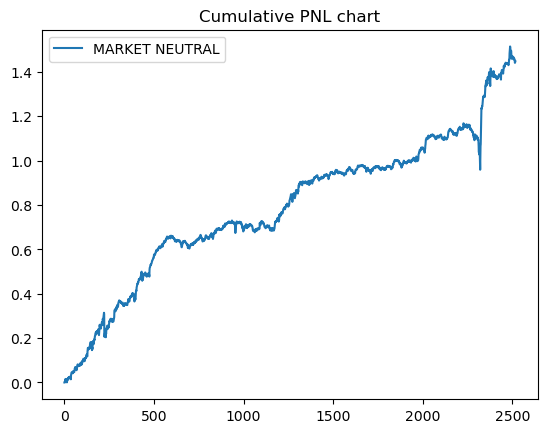

Stressed period return during Covid19:  -13.609529615513896%
Stressed period return during Dec18:  3.5765779786037366%
Stressed period return during Fall2015:  2.147954666945533%
Stressed period return during Oct14:  0.4763952234596674%
Stressed period return during Aug2013:  -0.11368183480925491%



In [44]:
pnl_df = signal_df * return_df.shift(-1)                                    #BASED ON YESTERDAY'S INFORMATION, WE EXECUTE AT TODAY'S CLOSE PRICES AND COMPUTE OUR PNL BASED ON TOMORROW'S RETURN
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "MARKET NEUTRAL")
marketneutralportfolio = signal_df.copy(deep=True)


PERFORMANCE STATISTICS FOR SECTOR NEUTRAL
Daily annualized sharpe: 1.7791742805753734
Average annual returns: 15.226439863974802%
Total returns: 152.08313149851023%
Max drawdown: -15.52335198506758%


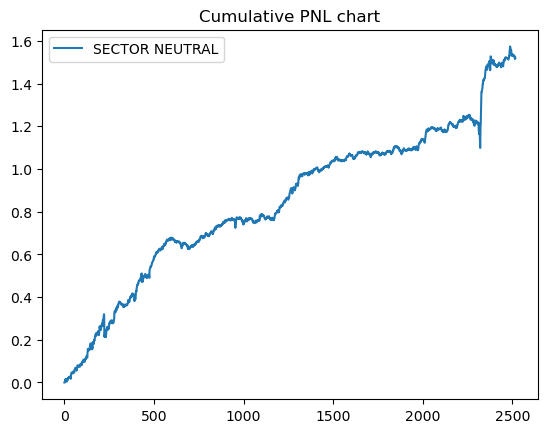

Stressed period return during Covid19:  -11.462535953198698%
Stressed period return during Dec18:  3.3098623037572605%
Stressed period return during Fall2015:  1.8041572233077265%
Stressed period return during Oct14:  1.040614733573348%
Stressed period return during Aug2013:  -0.10501250844735983%


PERFORMANCE STATISTICS FOR NON MARKET NEUTRAL
Daily annualized sharpe: 0.4024204968959547
Average annual returns: 7.436236637866712%
Total returns: 74.27383975202585%
Max drawdown: -54.54342525622662%


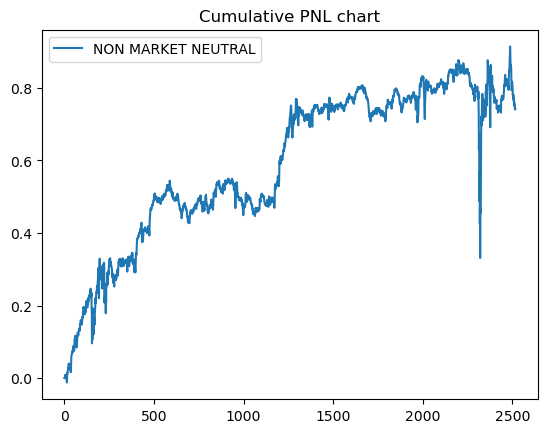

Stressed period return during Covid19:  -45.57849783540856%
Stressed period return during Dec18:  2.025367827520077%
Stressed period return during Fall2015:  4.52074956193484%
Stressed period return during Oct14:  -2.079332152242274%
Stressed period return during Aug2013:  0.19366211542666167%



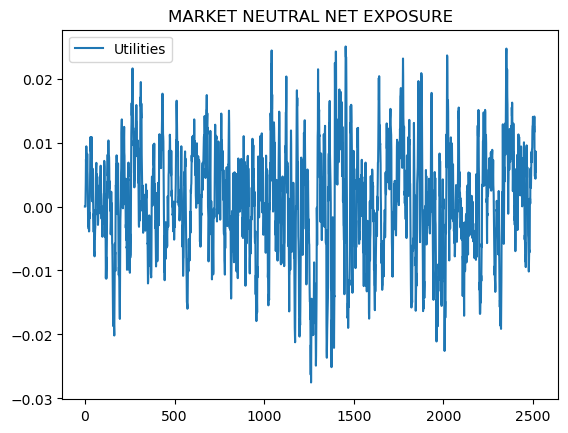

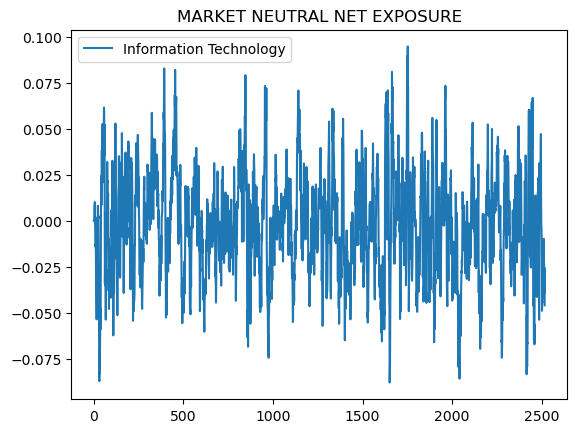

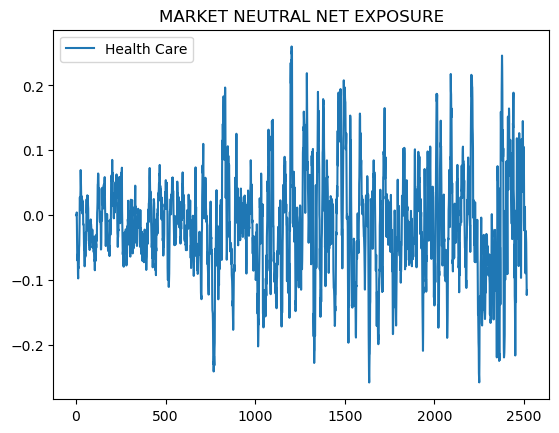

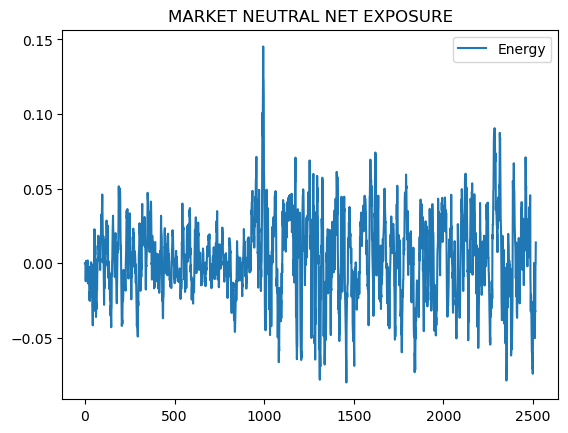

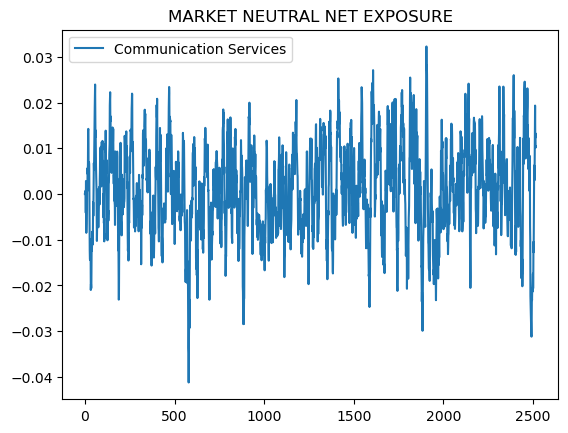

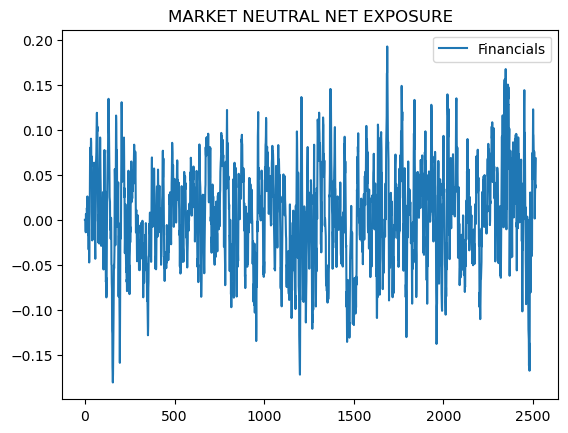

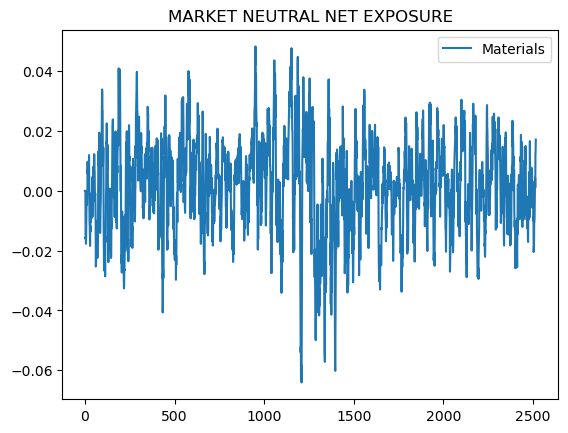

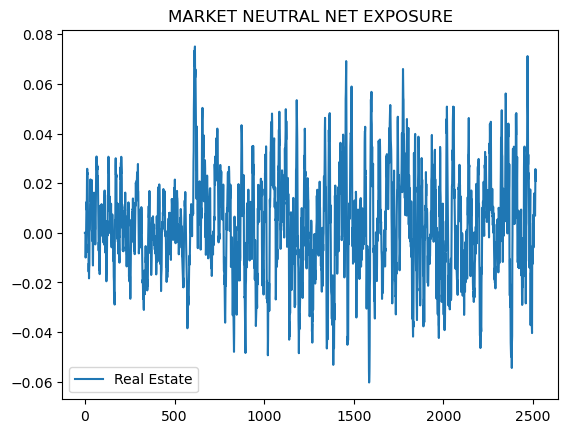

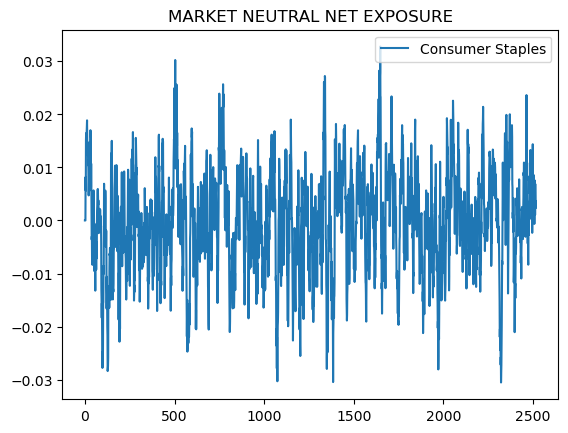

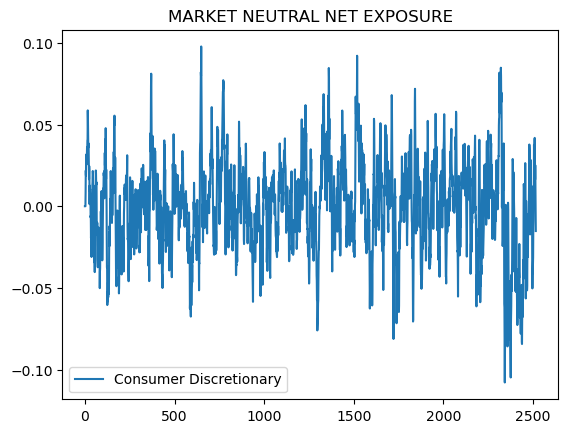

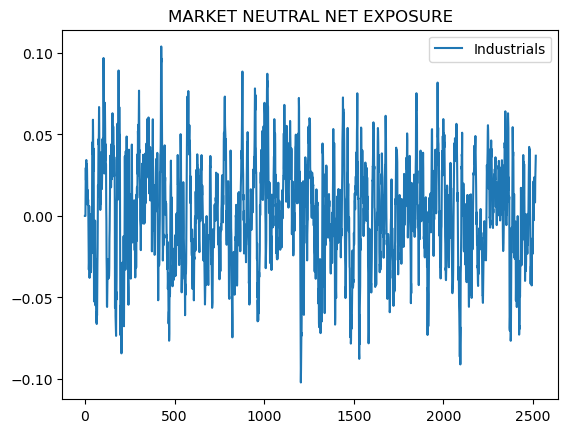

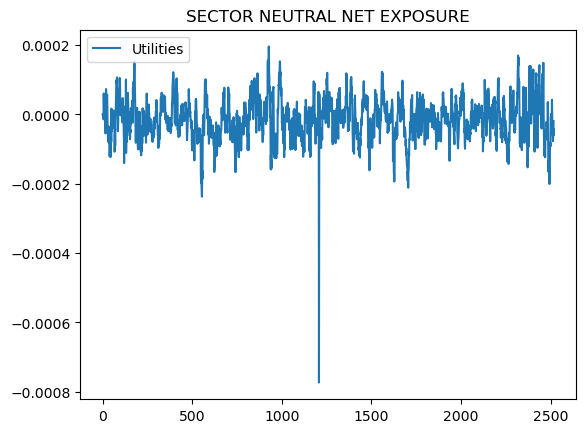

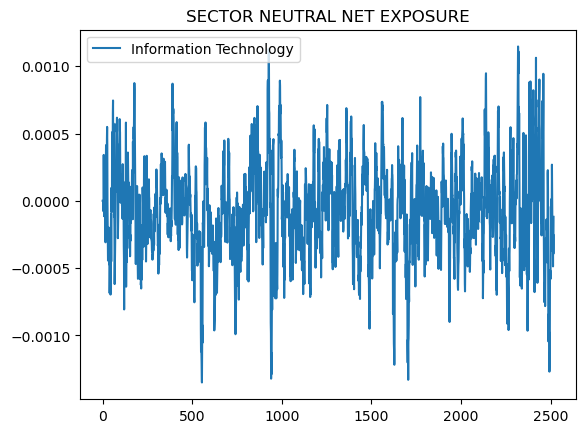

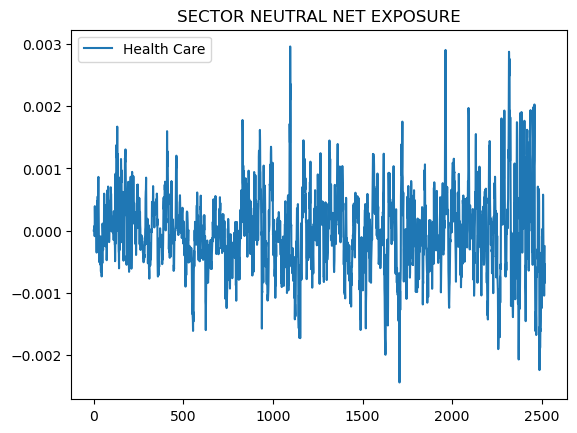

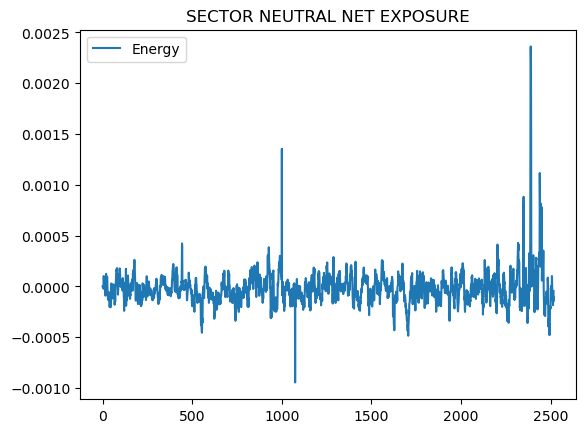

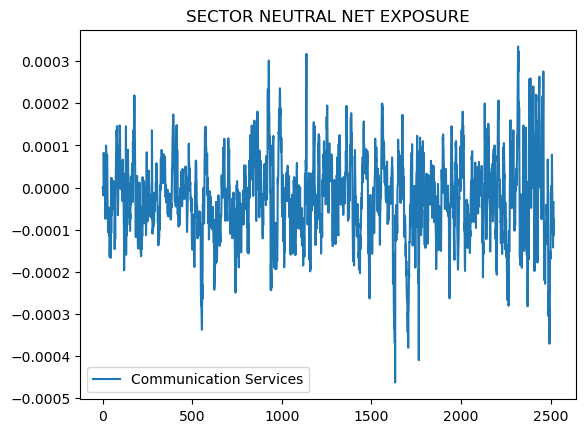

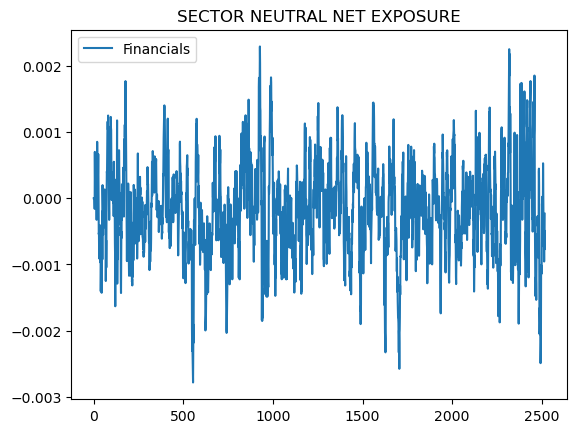

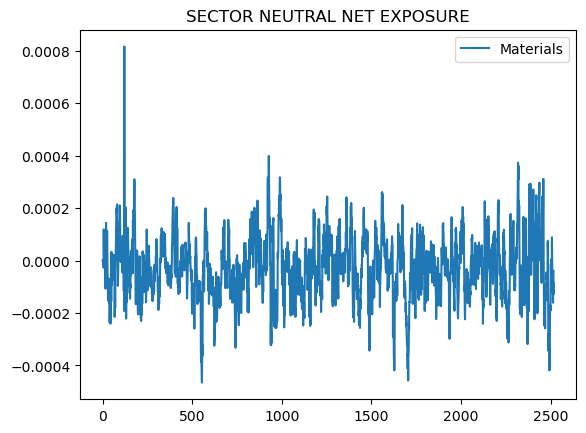

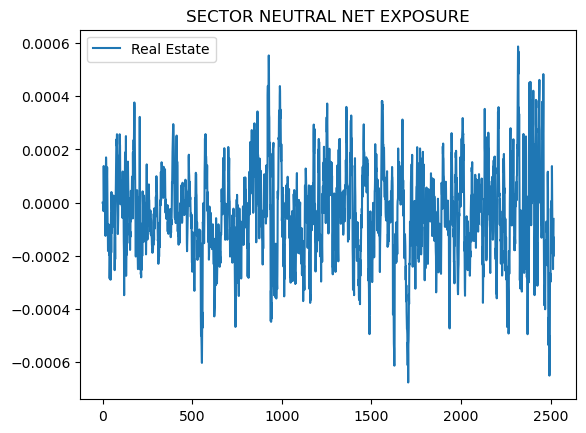

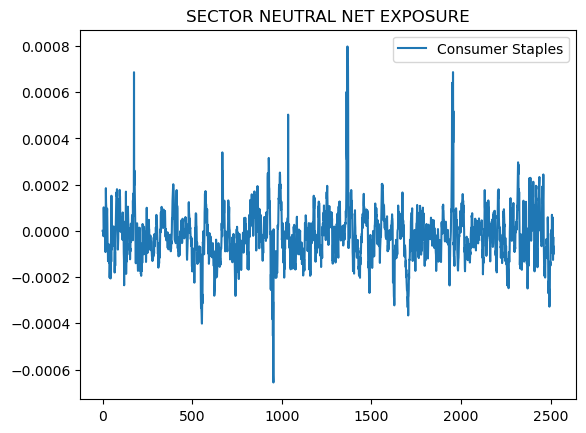

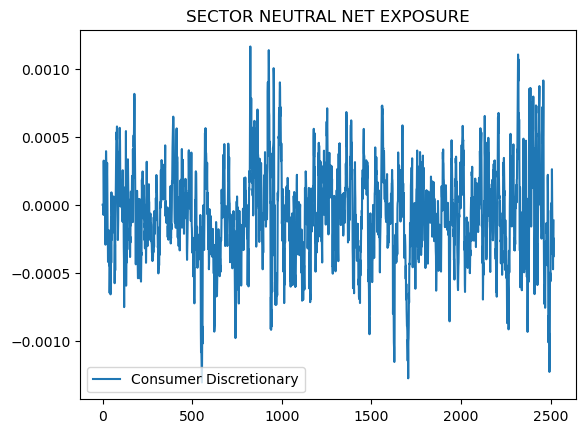

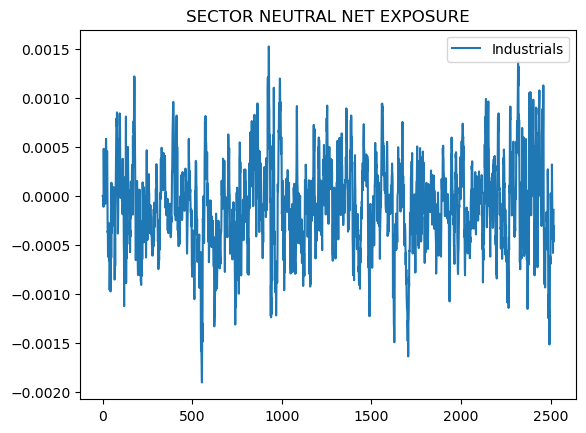

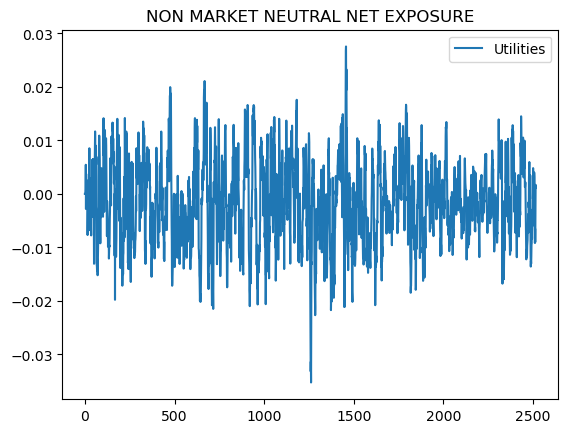

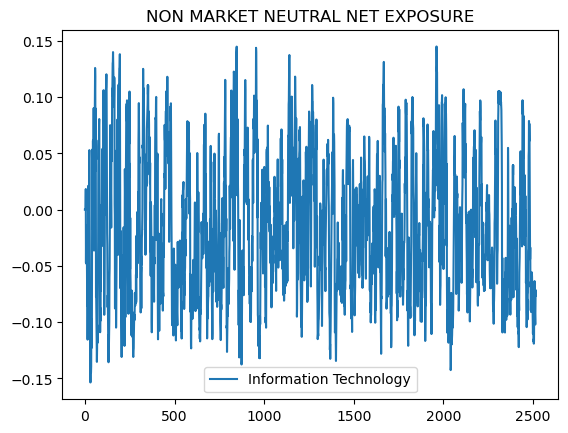

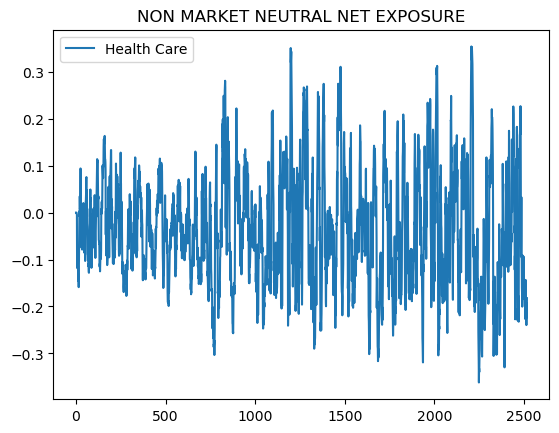

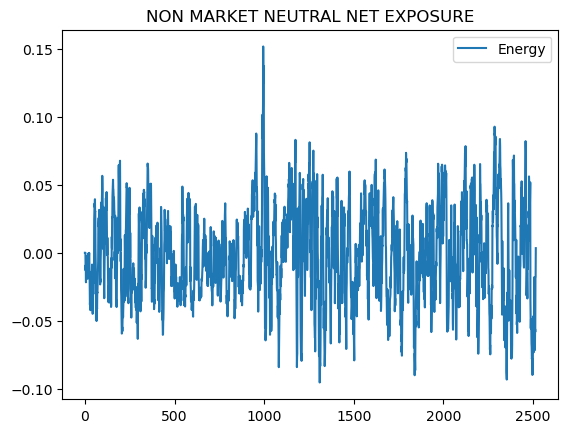

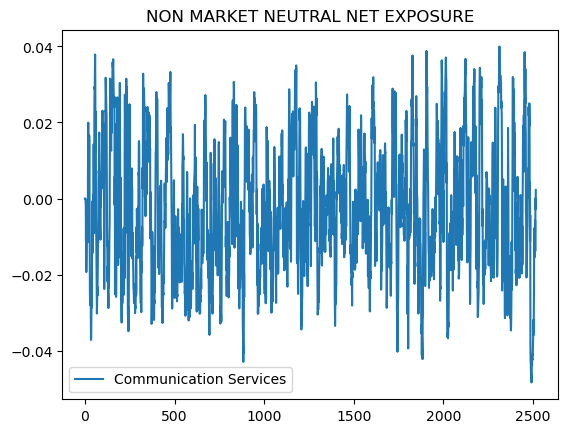

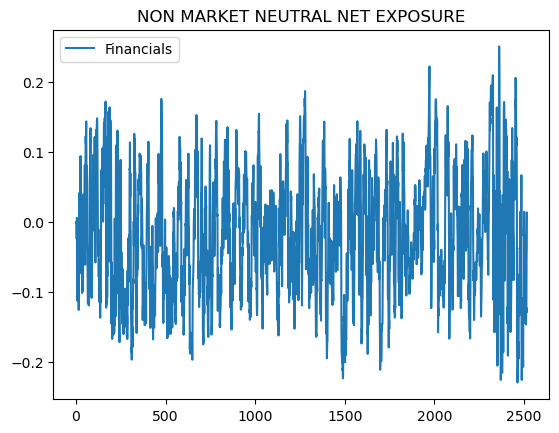

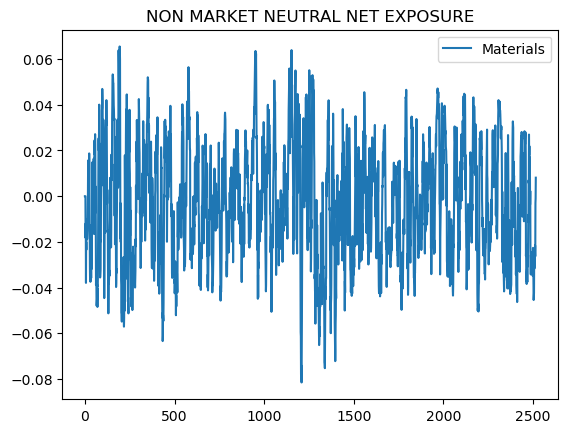

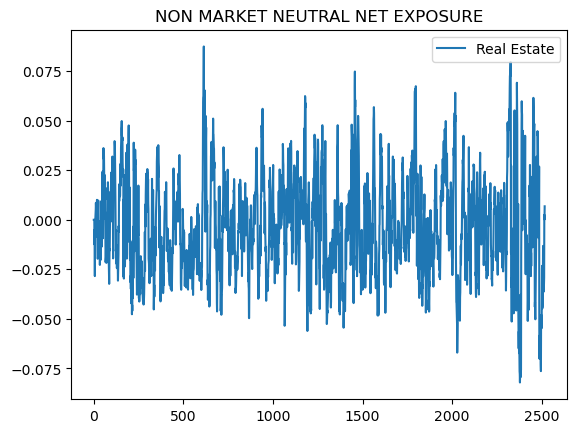

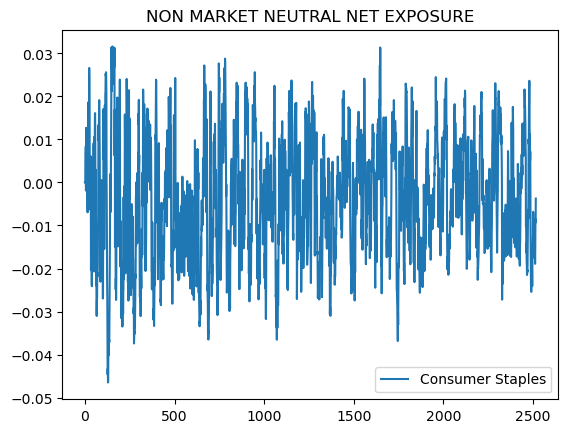

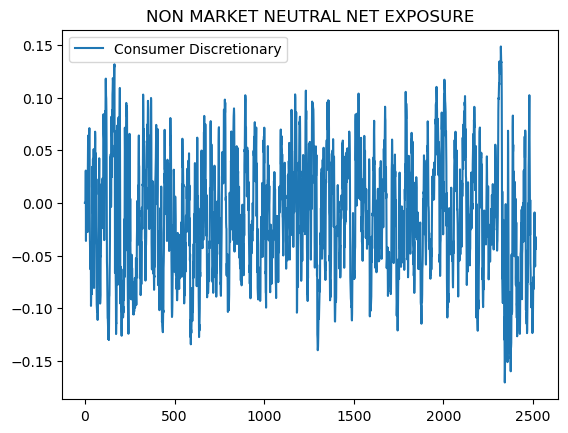

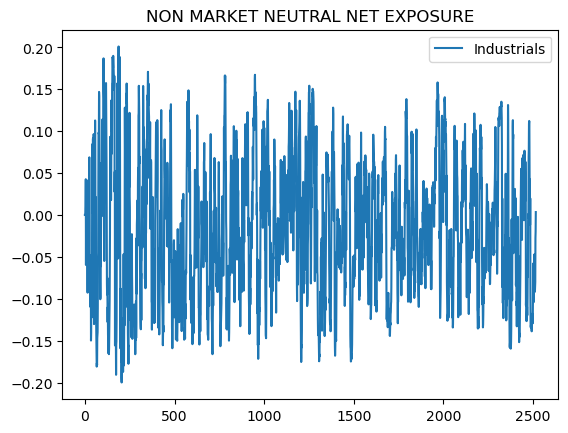

In [73]:
#SECTOR NEUTRAL STRATEGY BASED ON N DAY REVERSION, ALL STOCKS IN RUSSELL 2000
#sector_df = pd.read_csv("sector.csv", error_bad_lines = False)
sector_df = pd.read_csv("sector.csv", on_bad_lines = 'skip')
d = sector_df.set_index('ticker').to_dict()
signal_df2 = signal_df.copy(deep=True)                                      #WE JUST REUSE THE PORTFOLIO WEIGHTS FROM PREVIOUS STRATEGY, SINCE WE ARE JUST NEUTRALIZING DIFFERENTLY HERE
signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
uniquesector = list(set(signal_df2.columns))
for tsector in uniquesector:
    if (str(tsector)=='nan'):
        continue;
    tmean = signal_df2.loc[:, tsector].mean(axis=1)
    tmean[~np.isfinite(tmean)] = 0
    signal_df2.loc[:, tsector] = signal_df2.loc[:, tsector].subtract(tmean, axis='index');
signal_df = pd.DataFrame(data = signal_df2.values, index = signal_df.index, columns = signal_df.columns)
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "SECTOR NEUTRAL")
sectorneutralportfolio = signal_df.copy(deep=True)


#NON MARKET NEUTRAL STRATEGY BASED ON N DAY REVERSION, BASE UNIVERSE IS STOCKS IN RUSSELL 2000
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -return_df.rolling(reversiontimehorizon, min_periods = 3).mean()
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)

for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "NON MARKET NEUTRAL")
nonmarketneutralportfolio = signal_df.copy(deep=True)





portfolioDiagnostics(marketneutralportfolio, "MARKET NEUTRAL");
portfolioDiagnostics(sectorneutralportfolio, "SECTOR NEUTRAL");
portfolioDiagnostics(nonmarketneutralportfolio, "NON MARKET NEUTRAL");